In [1]:
from IPython.core.display import display, HTML
toggle_code_str = '''
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Toggle Code"></form>
'''

toggle_code_prepare_str = '''
    <script>
    function code_toggle() {
        if ($('div.cell.code_cell.rendered.selected div.input').css('display')!='none'){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
    }
    </script>

'''

display(HTML(toggle_code_prepare_str + toggle_code_str))

def toggle_code():
    display(HTML(toggle_code_str))

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from skbio.stats.ordination import pcoa
from umap import UMAP
from friendly_guacamole.datasets import (
    Dataset,
    QiitaTable,
    QiitaMetadata,
    GreenGenes97Tree,
)
from friendly_guacamole.transforms import (
    UniFrac,
    CLR,
    AsDense,
    RarefactionBIOM,
    PCoA,
    FilterSamples,
)
import matplotlib
import matplotlib.pyplot as plt

In [3]:
class OfficeStudy(Dataset):
    study_id = 10423
    table_artifact_id = 47845

    artifacts = {
        'metadata': QiitaMetadata(study_id),
        'table': QiitaTable(table_artifact_id),
        'tree': GreenGenes97Tree(),
    }

In [4]:
RAREFACTION_DEPTH = 1000
dataset = OfficeStudy('data/office')

Files already downloaded and verified


In [15]:
table = dataset['table']
tree = dataset['tree']


In [16]:
preprocessing = Pipeline([
    ('filter_samples', FilterSamples(RAREFACTION_DEPTH))
])

table = preprocessing.fit_transform(table)

In [17]:
table.sum('sample').shape

(1862,)

In [18]:
dm_pipeline = Pipeline([
    ('subsample', RarefactionBIOM(RAREFACTION_DEPTH)),
    ('unifrac', UniFrac(dataset.apply('tree', 'path'))),
])
dm = dm_pipeline.fit_transform(table)

In [9]:
metadata = dataset['metadata'].set_index('sample_name')
y = metadata.loc[table.ids('sample')]


In [10]:
X = PCoA(metric='precomputed').fit_transform(dm)

/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.05176547174158078 and the largest is 51.18261194476099.
  warn(


In [27]:
U1 = UMAP(metric='precomputed', n_components=1, random_state=724).fit_transform(dm)

/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


In [28]:
U2 = UMAP(metric='precomputed', n_components=2, random_state=824).fit_transform(dm)

/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


One component

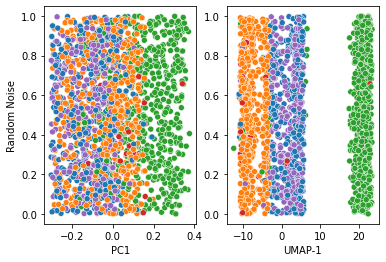

In [29]:
toggle_code()

noise_like = np.random.uniform(size=len(X['PC1']))
fig, axs = plt.subplots(1, 2)
g0 = sns.scatterplot(
    x=X['PC1'],
    y=noise_like,
    # hue=y['period']
    hue=y['period'].tolist(),
    ax=axs[0],
    legend=False
)
g0.set_ylabel('Random Noise')
# g0.set_aspect('equal')
g1 = sns.scatterplot(
    x=pd.Series(U1[:, 0], name='UMAP-1'),
    y=noise_like,
    hue=y['period'].tolist(),
    ax=axs[1],
    legend=False,
)
plt.savefig('results/office-study-1d-batch-effect-embeddding.png')
plt.show()

Two component

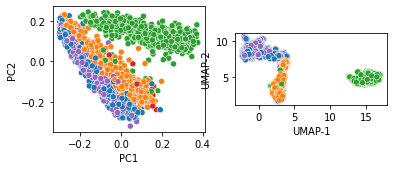

In [30]:
toggle_code()

noise_like = np.random.uniform(size=len(X['PC1']))
fig, axs = plt.subplots(1, 2)
g0 = sns.scatterplot(
    x=X['PC1'],
    y=X['PC2'],
    # hue=y['period']
    hue=y['period'].tolist(),
    ax=axs[0],
    legend=False
)
g0.set_ylabel('PC2')
g0.set_aspect('equal')
g1 = sns.scatterplot(
    x=pd.Series(U[:, 0], name='UMAP-1'),
    y=pd.Series(U[:, 1], name='UMAP-2'),
    hue=y['period'].tolist(),
    ax=axs[1],
    legend=False,
)
g1.set_aspect('equal')
plt.savefig('results/office-study-2d-batch-effect-embeddding.png')
plt.show()
